In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Batch, Data

import numpy as np
import matplotlib.pyplot as plt

from layers.ect import EctLayer
from layers.config import EctConfig


from datasets.mnist import MnistDataModule 
from datasets.config import MnistDataModuleConfig

from pytranskit.optrans.continuous.cdt import CDT


dataset = MnistDataModule(MnistDataModuleConfig(root="./data/mnistpointcloud"))

for batch in dataset.train_dataloader():
    print(batch.x.shape)
    break

C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([9784, 2])


In [2]:
NUM_PTS = 100
DEVICE = 'cuda:0'
NUM_THETAS = 64

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
    ]
)


CONFIG = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,normalized=True,device=DEVICE)


In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = EctLayer(config = CONFIG,v=V)
        self.num_pts = NUM_PTS
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_THETAS**2,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512, 2*NUM_PTS) 
        )

    def forward(self, batch):
        _batch = batch.clone()
        _batch.ect = self.layer(_batch)
        _batch.x = self.encoder(_batch.ect).view(-1,2) 
        _batch.batch = torch.arange(batch.batch.max().item()+1,device=DEVICE).repeat_interleave(NUM_PTS)
        decoded = self.layer(_batch) 
        return decoded, _batch

In [4]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ectlayer = EctLayer(config = CONFIG, v=V)


In [5]:


# Point to training loop video
num_epochs = 3
for epoch in range(num_epochs):
    for batch in dataset.train_dataloader():
        batch = batch.to(DEVICE)
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon, _ = model(batch)
        batch_ect = ectlayer(batch) 
        loss = criterion(recon, batch_ect)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.6f}')

Epoch:1, Loss:0.000262
Epoch:2, Loss:0.000271
Epoch:3, Loss:0.000175


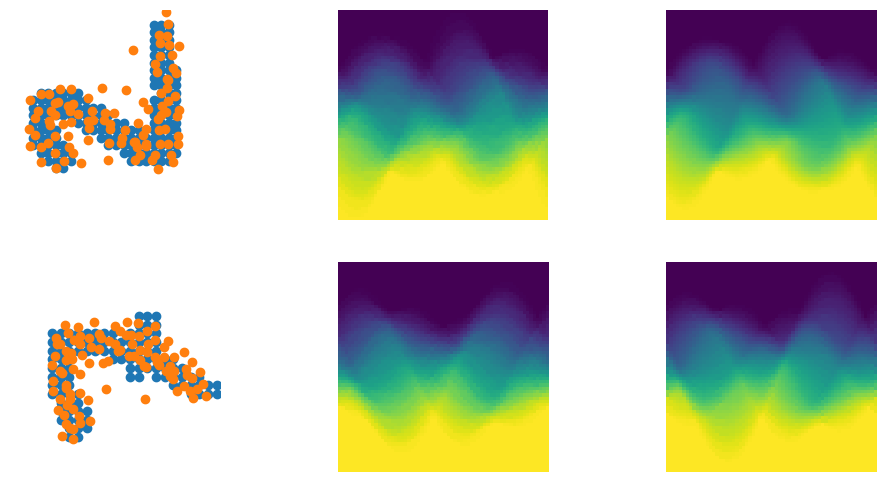

In [6]:
for test_batch in dataset.test_dataloader():
    break

recon_batch, internal_batch = model(test_batch.to(DEVICE))


fig, axes = plt.subplots(2,3,figsize=(12,6))

for plt_idx,idx in enumerate([1,41]):
    pred = internal_batch.x[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS].cpu().detach().numpy()
    points = test_batch[idx].x.cpu().detach().numpy()

    # fig, axes = plt.subplots(nrows=2, ncols=2)
    # fig.suptitle(f"{test_batch[idx].y.item()}", fontsize=20)

    # Plot the point clouds
    ax = axes[plt_idx,0]
    ax.axis("off")
    ax.scatter(points[:,0],points[:,1])
    ax.scatter(pred[:,0],pred[:,1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)

    # Plot the reconstructed ect
    ax = axes[plt_idx,1]
    ax.axis("off")
    ax.imshow(recon_batch[idx].cpu().squeeze().detach().numpy())

    # Plot the ect of the original
    ax = axes[plt_idx,2]
    ax.axis("off")
    ax.imshow(internal_batch.ect[idx].cpu().squeeze().detach().numpy())


In [7]:
internal_batch.ect.shape

torch.Size([64, 64, 64])

# Sample from latent space

We load the trained variational autoencoder to generate new ect's and decode
them using our previously trained model. 


In [8]:
from model import VanillaVAE

vae_model = VanillaVAE(in_channels=1, latent_dim=3200)
vae_model.load_state_dict(torch.load("model.pt"))
vae_model.eval().to(DEVICE)


VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

torch.Size([3, 1, 64, 64])
torch.Size([300, 2])


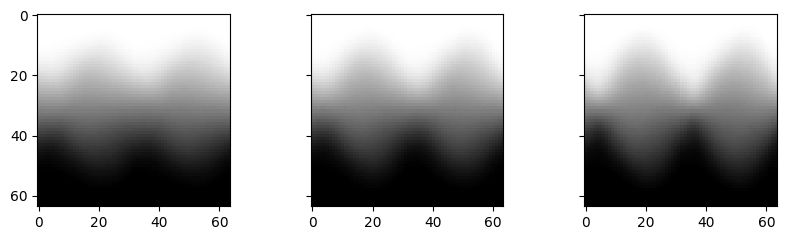

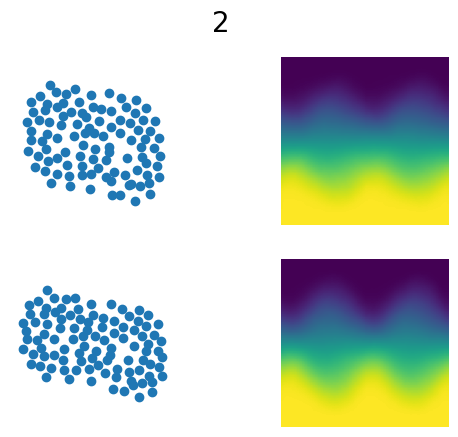

In [61]:

NUM_IMAGES = 3
latent_size = 3200

with torch.no_grad():

    ##########################
    ### RANDOM SAMPLE
    ##########################

    rand_features = torch.randn(NUM_IMAGES, latent_size).to(DEVICE)
    new_images = vae_model.decode(rand_features)
    print(new_images.shape)
    color_channels = new_images.shape[1]
    image_height = new_images.shape[2]
    image_width = new_images.shape[3]

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 32

    fig, axes = plt.subplots(
        nrows=1, ncols=NUM_IMAGES, figsize=(10, 2.5), sharey=True
    )
    decoded_images = new_images[:NUM_IMAGES]

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device("cpu"))

        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax.imshow(curr_img)
        else:
            ax.imshow(curr_img.view((64, 64)), cmap="binary")

x = model.encoder(new_images).view(-1,2)
print(x.shape)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(f"{test_batch[idx].y.item()}", fontsize=20)

for plt_idx,idx in enumerate([0,1]):
    pred = x[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS,:].cpu().detach().numpy()
    

    # Plot the point clouds
    ax = axes[plt_idx,0]
    ax.axis("off")
    ax.scatter(pred[:,0],pred[:,1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)

    # Plot the reconstructed ect
    ax = axes[plt_idx,1]
    ax.axis("off")
    ax.imshow(new_images[idx].cpu().squeeze().detach().numpy())


# Do autoencoding


torch.Size([200, 2])


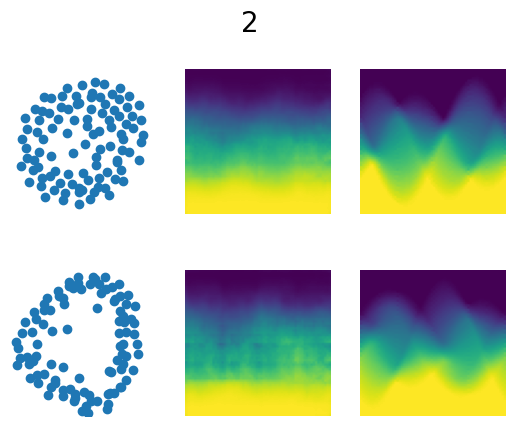

In [36]:
ectbatch = ectlayer(test_batch)
vae_model.eval()
# decoded, theinput, z_mean, z_log_var = vae_model(ectbatch.unsqueeze(1).to(DEVICE))
decoded, theinput, z_mean, z_log_var = vae_model(torch.zeros(2,1,64,64).to(DEVICE))


x = model.encoder(decoded).view(-1,2)

print(x.shape)

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.suptitle(f"{test_batch[idx].y.item()}", fontsize=20)

for plt_idx,idx in enumerate([0,1]):
    pred = x[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS,:].cpu().detach().numpy()
    

    # Plot the point clouds
    ax = axes[plt_idx,0]
    ax.axis("off")
    ax.scatter(pred[:,0],pred[:,1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)

    # Plot the reconstructed ect
    ax = axes[plt_idx,1]
    ax.axis("off")
    ax.imshow(decoded[idx].cpu().squeeze().detach().numpy())
    
    # Plot the original ect
    ax = axes[plt_idx,2]
    ax.axis("off")
    ax.imshow(ectbatch[idx].cpu().squeeze().detach().numpy())


In [11]:
# With Learnable Parameters
m = nn.BatchNorm2d(100)
# Without Learnable Parameters
m = nn.BatchNorm2d(100, affine=False)
input = torch.zeros(20, 100, 35, 45)
output = m(input)
output

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

torch.Size([64, 1, 64, 64])


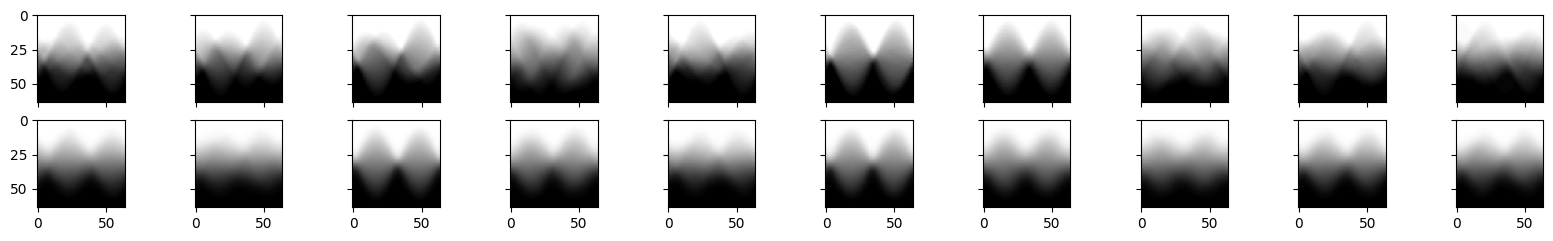

In [67]:
data_loader = dataset.train_dataloader()
device = DEVICE
unnormalizer = (None,)
figsize = (20, 2.5)
n_images = 10


V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
    ]
)

layer = EctLayer(
    EctConfig(num_thetas=64, bump_steps=64, normalized=True, device=DEVICE), v=V
)




fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize
)

for batch_idx, features in enumerate(data_loader):

    features = layer(features.to(device)).unsqueeze(1)

    color_channels = features.shape[1]
    image_height = features.shape[2]
    image_width = features.shape[3]

    with torch.no_grad():
        decoded, theinput, z_mean, z_log_var = vae_model(features)

    print(decoded.shape)

    orig_images = features[:n_images]
    decoded[:n_images]
    break

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded]):
        curr_img = img[i].detach().to(torch.device("cpu"))

        ax[i].imshow(curr_img.view((image_height, image_width)), cmap="binary")

plt.show()
